In [2]:
import sys
import time

from IPython.display import clear_output
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

import casadi as cas
import control
import mujoco
import mujoco.viewer

from dynamics_model import Manipulator
from trajopt_setup import *

In [3]:
m_c = 0.25
m_p = 1
l_p_max = 0.5
l_p_min = 0.2
g = 9.81

## Cart translational DoFs
x_c = cas.SX.sym('x_c')
y_c = cas.SX.sym('y_c')
z_c = cas.SX.sym('z_c')

vx_c = cas.SX.sym('vx_c')
vy_c = cas.SX.sym('vy_c')
vz_c = cas.SX.sym('vz_c')

## Pole DoFs
x_p = cas.SX.sym('x_p')
y_p = cas.SX.sym('y_p')
r_p = cas.SX.sym('r_p')

vx_p = cas.SX.sym('vx_p')
vy_p = cas.SX.sym('vy_p')
vr_p = cas.SX.sym('vr_p')

## Configuration
q = cas.vertcat(x_c, y_c, z_c, x_p, y_p, r_p)
q_dot = cas.vertcat(vx_c, vy_c, vz_c, vx_p, vy_p, vr_p)
u = cas.SX.sym('u', 3)

## Configuration ground
q_ground = cas.vertcat(x_c, y_c, x_p, y_p, r_p)
q_dot_ground = cas.vertcat(vx_c, vy_c, vx_p, vy_p, vr_p)
x_ground = cas.vertcat(q_ground, q_dot_ground)

## Intermediate variables
z_p = cas.sqrt(r_p**2 - x_p**2 - y_p**2)
vz_p = cas.gradient(z_p, q_ground).T @ q_dot_ground

## Ground energies
T_ground = 0.5*m_c*(vx_c**2 + vy_c**2) + 0.5*m_p*((vx_c+vx_p)**2 + (vy_c+vy_p)**2 + vz_p**2)
V_ground = m_p*g*z_p

## Ground matrices
M_ground = Manipulator.generate_M(T_ground, q_dot_ground)
C_ground = Manipulator.generate_C(M_ground, q_ground, q_dot_ground)
G_ground = Manipulator.generate_G(V_ground, q_ground)
B_ground = cas.SX([
  [1, 0, 0],
  [0, 1, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 1]
])

## Ground forward dynamics
f_ground = cas.Function('f_ground', [cas.vertcat(q_ground, q_dot_ground), u], [cas.vertcat(q_dot_ground, cas.inv(M_ground) @ (-C_ground@q_dot_ground - G_ground + B_ground@u))], ['x', 'u'], ['x_dot'])

In [4]:
## Linearize f

A = cas.DM.zeros(10, 10)
A[:5, 5:10] = cas.DM.eye(5)

B = cas.DM.zeros(10, 3)

f_A = cas.Function('f_A', [cas.vertcat(q_ground, q_dot_ground), u], [cas.jacobian(cas.inv(M_ground)@(-C_ground@q_dot_ground - G_ground + B_ground@u), cas.vertcat(q_ground, q_dot_ground))], ['x', 'u'], ['df_dx'])
A[5:10, :] = f_A([0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0], [0, 0, 9.81])
print('A: ', A)

f_B = cas.Function('f_B', [cas.vertcat(q_ground, q_dot_ground), u], [cas.jacobian(cas.inv(M_ground)@(-C_ground@q_dot_ground - G_ground + B_ground@u), u)], ['x', 'u'], ['df_du'])
B[5:10, :] = f_B([0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0], [0, 0, 9.81])
print('B: ', B)

K, S, E = control.lqr(A, B, 50*np.eye(10), np.eye(3))
print('K: ', K)

A:  
[[0, 0, 0, 0, 0, 1, 00, 00, 00, 00], 
 [0, 0, 0, 0, 0, 00, 1, 00, 00, 00], 
 [0, 0, 0, 0, 0, 00, 00, 1, 00, 00], 
 [0, 0, 0, 0, 0, 00, 00, 00, 1, 00], 
 [0, 0, 0, 0, 0, 00, 00, 00, 00, 1], 
 [00, 00, -196.2, 0, 0, 00, 00, 0, 0, 0], 
 [00, 00, 0, -196.2, 0, 00, 00, 0, 0, 0], 
 [00, 00, 245.25, 0, 0, 00, 00, -0, -0, -0], 
 [00, 00, 0, 245.25, 0, 00, 00, 0, 0, 0], 
 [00, 00, 0, 0, 0, 00, 00, 0, 0, 0]]
B:  
[[0, 0, 0], 
 [0, 0, 0], 
 [0, 0, 0], 
 [0, 0, 0], 
 [0, 0, 0], 
 [4, 0, 0], 
 [0, 4, 0], 
 [-4, -0, -0], 
 [-0, -4, 0], 
 [0, 0, 1]]
K:  [[-7.07106781e+00 -6.22472173e-14 -2.17709614e+02 -7.77232817e-13
  -5.65071670e-15 -9.75154051e+00 -6.86534421e-14 -2.40805067e+01
  -9.41004095e-14 -2.58850992e-16]
 [-1.12501346e-13 -7.07106781e+00 -1.24202323e-12 -2.17709614e+02
   2.75937395e-15 -1.34229440e-13 -9.75154051e+00 -1.59676408e-13
  -2.40805067e+01  4.67824658e-15]
 [ 3.02407583e-16 -1.65181970e-14  9.14911150e-15 -1.02111762e-13
   7.07106781e+00  6.28744540e-16 -1.46504881e-14 

In [5]:
def mujoco_to_casadi(qpos, qvel):
    theta = qpos[3]
    phi = qpos[4]
    r_p = qpos[5] + 0.2

    x_p = r_p * np.cos(phi) * np.sin(theta) # can simply scale by r_p since unit quat
    y_p = r_p * np.sin(phi)
    
    theta_dot = qvel[3]
    phi_dot = qvel[4]
    r_p_dot = qvel[5]
    
    x_p_dot = r_p_dot*np.cos(phi)*np.sin(theta) - r_p*phi_dot*np.sin(phi)*np.sin(theta) + r_p*theta_dot*np.cos(phi)*np.cos(theta)
    y_p_dot = r_p_dot*np.sin(phi) + r_p*phi_dot*np.cos(phi)
    
    return np.array([
        qpos[0],
        qpos[1],
        x_p,
        y_p,
        r_p,
        qvel[0],
        qvel[1],
        x_p_dot,
        y_p_dot,
        r_p_dot
    ])

In [6]:
multiple = 20
N = int(500 / multiple)

In [7]:
%%script false --no-raise-error
# RUN IF OPTIMIZING & SAVING NEW TRAJECTORY

variable_lower_bounds, variable_upper_bounds, variable_initial_conditions, constraints, constraint_lower_bounds, constraint_upper_bounds = get_data_structures()

timestep_lower_bound = 1/float(N)
timestep_upper_bound = 1/float(N)

initial_state = [-1, 0, 0, 0, 0.3, 0, 0.5, 0, 0, 0]
final_state = [0, 0, 0.1, 0, 0.5, 2.5, 0, -0.1, 0, 2]

global_lower_bounds = [-np.inf, -np.inf, -l_p_min*np.sin(np.pi/3), -l_p_min*np.sin(np.pi/3), l_p_min, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
global_upper_bounds = [np.inf, np.inf, l_p_min*np.sin(np.pi/3), l_p_min*np.sin(np.pi/3), l_p_max, np.inf, np.inf, np.inf, np.inf, np.inf]

populate_list_properties(variable_lower_bounds, global_lower_bounds, [-100, -100, -100], timestep_lower_bound, N)
populate_list_properties(variable_upper_bounds, global_upper_bounds, [100, 100, 100], timestep_upper_bound, N)

populate_list_properties(variable_initial_conditions, initial_state, [0, 0, 0], timestep_upper_bound, N)
set_boundary_conditions(variable_lower_bounds, variable_upper_bounds, initial_state, initial_state, 0)
set_boundary_conditions(variable_lower_bounds, variable_upper_bounds, final_state, final_state, N-1)

state_variables_list, input_variables_list = populate_variables_and_constraints(10, 3, constraints, constraint_lower_bounds, constraint_upper_bounds, f_ground, N)

# cost function out here
J = 0
for input_variable in input_variables_list:
  J += input_variable.T @ input_variable

variables = state_variables_list + input_variables_list

variable_lower_bounds = np.hstack(variable_lower_bounds)
variable_upper_bounds = np.hstack(variable_upper_bounds)
variable_initial_conditions = np.hstack(variable_initial_conditions)
constraint_lower_bounds = np.hstack(constraint_lower_bounds)
constraint_upper_bounds = np.hstack(constraint_upper_bounds)
variables = cas.vertcat(*variables)
constraints = cas.vertcat(*constraints)

print('variables: ', variables.shape)
print('variable lower bounds: ', variable_lower_bounds.shape)
print('variable upper bounds: ', variable_upper_bounds.shape)
print('variable initial conditions: ', variable_initial_conditions.shape)
print('constraints: ', constraints.shape)
print('constraint lower bounds: ', constraint_lower_bounds.shape)
print('constraint upper bounds: ', constraint_upper_bounds.shape)

nlp = {'f':J, 'x':variables, 'g':constraints}
solver = cas.nlpsol('solver', 'ipopt', nlp)
res = solver(x0=variable_initial_conditions, lbx=variable_lower_bounds, ubx=variable_upper_bounds, ubg=constraint_upper_bounds, lbg=constraint_lower_bounds)

output = res['x'].full()
filename = str(initial_state).replace(' ', '') + 'to' + str(final_state).replace(' ', '') + 'interpolated.csv'
np.savetxt(filename, output, delimiter=',')

In [8]:
# RUN IF LOADING SAVED TRAJECTORY
output = np.array([np.loadtxt("[-1,0,0,0,0.3,0,0.5,0,0,0]to[0,0,0.1,0,0.5,2.5,0,-0.1,0,2]interpolated.csv", delimiter=",")]).T

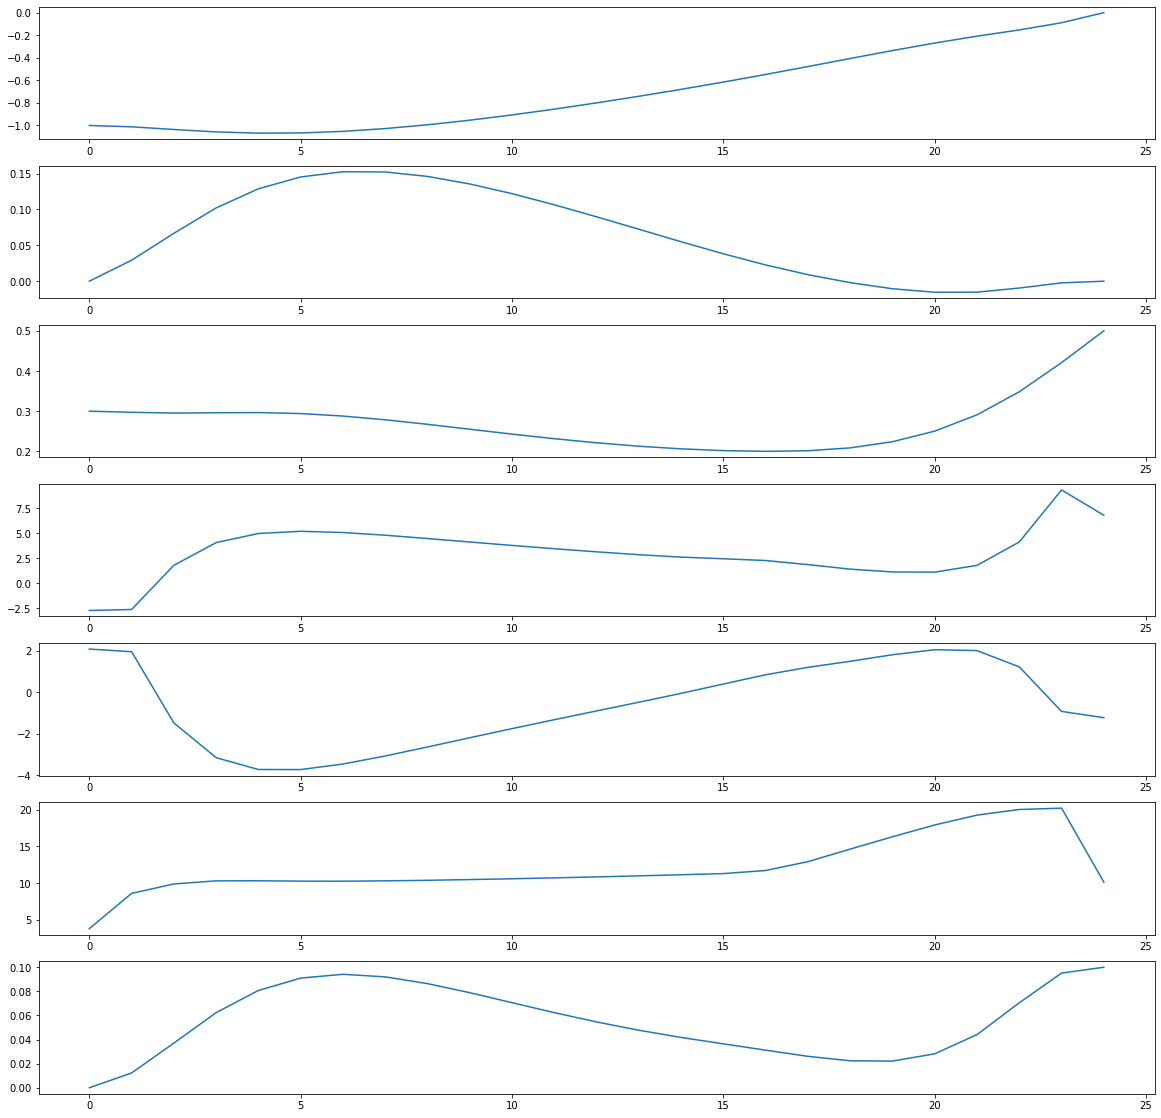

In [9]:
timesteps = np.arange(0, N, 1)

x_c_traj = extract_variable_array(output, 1, 10, N)
y_c_traj = extract_variable_array(output, 2, 10, N)
r_p_traj = extract_variable_array(output, 5, 10, N)
x_p_traj = extract_variable_array(output, 3, 10, N)

ux_traj = extract_variable_array(output, 1+10*N, 3, N)
uy_traj = extract_variable_array(output, 2+10*N, 3, N)
ur_traj = extract_variable_array(output, 3+10*N, 3, N)

plt.figure(figsize=(20, 20))

ax1 = plt.subplot(711)
plt.plot(timesteps, x_c_traj)

ax2 = plt.subplot(712, sharex=ax1)
plt.plot(timesteps, y_c_traj)

ax3 = plt.subplot(713, sharex=ax1)
plt.plot(timesteps, r_p_traj)

ax4 = plt.subplot(714, sharex=ax1)
plt.plot(timesteps, ux_traj)

ax5 = plt.subplot(715, sharex=ax1)
plt.plot(timesteps, uy_traj)

ax6 = plt.subplot(716, sharex=ax1)
plt.plot(timesteps, ur_traj)

ax7 = plt.subplot(717, sharex=ax1)
plt.plot(timesteps, x_p_traj)

plt.show()

In [10]:
m = mujoco.MjModel.from_xml_path('2d-jumping-cartpole.xml')
d = mujoco.MjData(m)

timesteps_sim = np.arange(0, int(N*multiple), 1)

# Track cumulative trajectories
mujoco_traj = []

# Set initial conditions (note that mujoco has z_c DoF while casadi model does not)
d.qpos[2] = 0.0525 # Always set

# [-1,0,0,0,0.25,0,0,0,0,0]
# d.qpos[0] = -1
# d.qpos[5] = 0.1 # 0.3 - l_p_min
# d.qvel[1] = 0

# [-1,0,0,0,0.25,0,0.5,0,0,0]
d.qpos[0] = -1
d.qpos[5] = 0.1 # 0.3 - l_p_min
d.qvel[1] = 0.5

cumulative_error_norm = 0

with mujoco.viewer.launch_passive(m, d) as viewer:
  start = time.time()

  for i in timesteps_sim:
    step_start = time.time()
    
    alpha = float(i % multiple) / float(multiple)
    
    if int(i/multiple) == N-1:
      ux_interpolated = ux_traj[int(i/multiple), 0]
      uy_interpolated = uy_traj[int(i/multiple), 0]
      ur_interpolated = ur_traj[int(i/multiple), 0]
      output_interpolated = output[1 + int(i/multiple)*10 : 1 + (1 + int(i/multiple))*10, 0]
    else:
      ux_interpolated = (1-alpha)*ux_traj[int(i/multiple), 0] + alpha*ux_traj[1 + int(i/multiple), 0]
      uy_interpolated = (1-alpha)*uy_traj[int(i/multiple), 0] + alpha*uy_traj[1 + int(i/multiple), 0]
      ur_interpolated = (1-alpha)*ur_traj[int(i/multiple), 0] + alpha*ur_traj[1 + int(i/multiple), 0]
      output_interpolated = (1-alpha)*output[1 + int(i/multiple)*10 : 1 + (1 + int(i/multiple))*10, 0] + alpha*output[1 + (1 + int(i/multiple))*10 : 1 + (2 + int(i/multiple))*10, 0]
    
    current_state = mujoco_to_casadi(d.qpos, d.qvel)
      
    error = current_state - output_interpolated
    cumulative_error_norm += error.T @ error
    u_bar = -K @ error
    
    d.ctrl[0] = ux_interpolated + u_bar[0]
    d.ctrl[1] = uy_interpolated + u_bar[1]
    d.ctrl[2] = ur_interpolated + u_bar[2]
    
    # Take the step
    mujoco.mj_step(m, d)

    # Collect mujoco traj
    mujoco_traj.append(mujoco_to_casadi(d.qpos, d.qvel))

    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()
    
    time.sleep(0.01)

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = m.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)
  
  for i in range(200):
    d.ctrl[0] = 0
    d.ctrl[1] = 0
    mujoco.mj_step(m, d)
    viewer.sync()
    time.sleep(0.01)

In [11]:
x_traj = output[1:1+N*10]
u_traj = output[1+N*10:1+N*10+N*3]

u_traj_reshaped = np.reshape(u_traj, (N, 3))
x_traj_reshaped = np.reshape(x_traj, (N, 10))

x_original = np.arange(25)
x_interp = np.linspace(0, 24, num=481)  # 25 original points expanded to 500 (last row handled separately)
x_interp_func = sp.interpolate.interp1d(x_original, x_traj_reshaped, axis=0, kind="linear")
x_traj_interpolated = np.vstack((x_interp_func(x_interp), np.tile(x_traj_reshaped[-1], (19, 1))))

u_original = np.arange(25)
u_interp = np.linspace(0, 24, num=481)  # 25 original points expanded to 500 (last row handled separately)
u_interp_func = sp.interpolate.interp1d(u_original, u_traj_reshaped, axis=0, kind="linear")
u_traj_interpolated = np.vstack((u_interp_func(u_interp), np.tile(u_traj_reshaped[-1], (19, 1))))

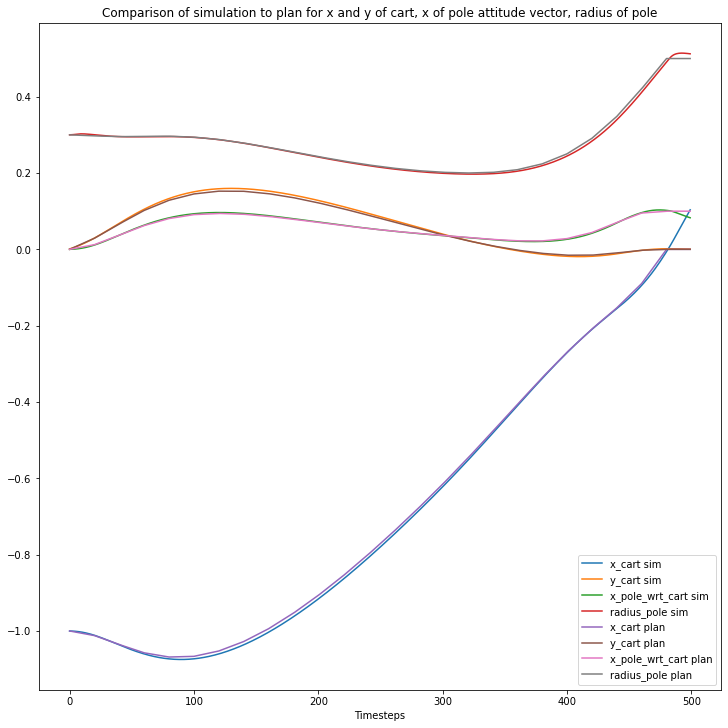

In [ ]:
mujoco_traj = np.vstack(mujoco_traj)

end_step = 500

fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
fig.patch.set_alpha(1)  # solution
ax.set_title('Comparison of simulation to plan for x and y of cart, x of pole attitude vector, radius of pole')
ax.set_xlabel('Timesteps')
ax.plot(timesteps_sim[:end_step], mujoco_traj[:end_step,0])
ax.plot(timesteps_sim[:end_step], mujoco_traj[:end_step,1])
ax.plot(timesteps_sim[:end_step], mujoco_traj[:end_step,2])
ax.plot(timesteps_sim[:end_step], mujoco_traj[:end_step,4])
ax.plot(timesteps_sim[:end_step], x_traj_interpolated[:end_step, 0])
ax.plot(timesteps_sim[:end_step], x_traj_interpolated[:end_step, 1])
ax.plot(timesteps_sim[:end_step], x_traj_interpolated[:end_step, 2])
ax.plot(timesteps_sim[:end_step], x_traj_interpolated[:end_step, 4])
ax.legend(['x_cart sim', 'y_cart sim', 'x_pole_wrt_cart sim', 'radius_pole sim', 'x_cart plan', 'y_cart plan', 'x_pole_wrt_cart plan', 'radius_pole plan'])
# plt.savefig('a.png', bbox_inches='tight', pad_inches=0.2)